In [1]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import numpy as np
from sklearn import datasets
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [2]:
# ---------------------------------------------------------
# 1. Generate Synthetic Data (Manual Gaussian Distributions)
# ---------------------------------------------------------
print("Generating synthetic data from random distributions...")

np.random.seed(42)
n_features = 3 # 3D Data
n_samples_per_class = 150
n_classes = 3

# Define Means (Separated to show clear clusters)
mean0 = [4, 4, 4]
mean1 = [-4, -4, -4]
mean2 = [0, 0, 0]

# Covariances
cov0 = np.eye(n_features) * 1.5
cov1 = np.eye(n_features) * 1.0
cov2 = np.eye(n_features) * 4.0 # "Mixer" class with high variance

# Generate
X0 = np.random.multivariate_normal(mean0, cov0, n_samples_per_class)
X1 = np.random.multivariate_normal(mean1, cov1, n_samples_per_class)
X2 = np.random.multivariate_normal(mean2, cov2, n_samples_per_class)

X = np.vstack((X0, X1, X2))
y = np.hstack((
    np.zeros(n_samples_per_class), 
    np.ones(n_samples_per_class), 
    np.full(n_samples_per_class, 2)
)).astype(int)

feature_names = [f'Feature {i+1}' for i in range(n_features)]
target_names = [f'Class {i}' for i in range(n_classes)]

df = pd.DataFrame(X, columns=feature_names)
df['species'] = [target_names[i] for i in y]

Generating synthetic data from random distributions...


In [3]:
# ---------------------------------------------------------
# 2. Compute LDA (Moved up to use in 3D plot)
# ---------------------------------------------------------
print("Computing LDA...")
# We fit LDA now so we can plot its vectors in the 3D graph
lda = LinearDiscriminantAnalysis(n_components=2)
X_r2 = lda.fit(X, y).transform(X)

Computing LDA...


Generating 3D Scatter Plot with Eigenvectors...


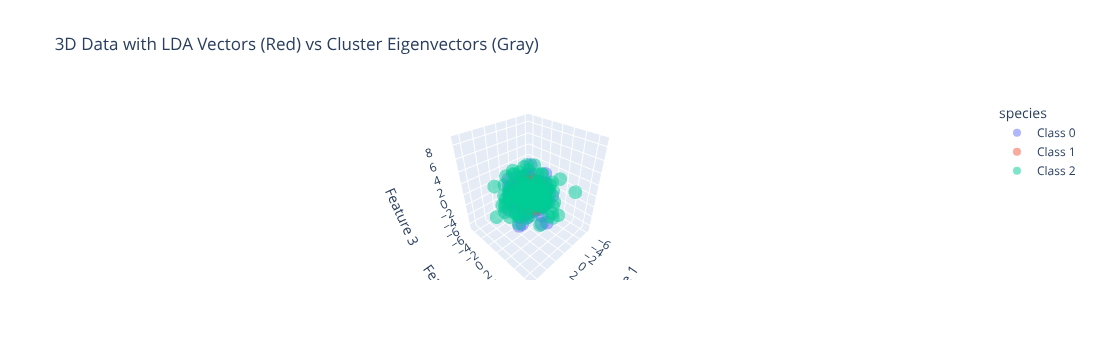

In [4]:
# ---------------------------------------------------------
# 3. Plot 1: 3D Scatter with Eigenvectors
# ---------------------------------------------------------
print("Generating 3D Scatter Plot with Eigenvectors...")

# Base 3D Scatter
fig_3d = px.scatter_3d(
    df,
    x='Feature 1',
    y='Feature 2',
    z='Feature 3',
    color='species',
    title='3D Data with LDA Vectors (Red) vs Cluster Eigenvectors (Gray)',
    opacity=0.5,
    size_max=8
)

fig_3d.show()

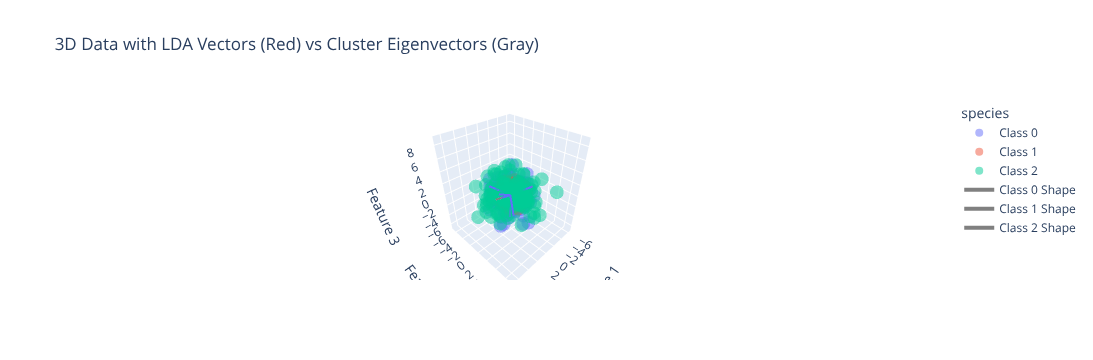

In [5]:
# --- A. Plot Per-Class Covariance Eigenvectors (The Shape of the Clusters) ---
unique_classes = np.unique(y)
for cls_idx in unique_classes:
    # Get data for this class
    class_data = X[y == cls_idx]
    class_mean = np.mean(class_data, axis=0)
    class_cov = np.cov(class_data, rowvar=False)
    
    # Calculate Eigenvalues and Eigenvectors
    vals, vecs = np.linalg.eigh(class_cov)
    
    # Draw all 3 eigenvectors for this class
    for i in range(len(vals)):
        vec = vecs[:, i]
        # Scale by std dev (sqrt of eigenvalue) for realistic sizing
        val = np.sqrt(vals[i]) * 2.0 
        
        end_point = class_mean + (vec * val)
        
        fig_3d.add_trace(go.Scatter3d(
            x=[class_mean[0], end_point[0]],
            y=[class_mean[1], end_point[1]],
            z=[class_mean[2], end_point[2]],
            mode='lines',
            line=dict(color='gray', width=4),
            name=f'Class {cls_idx} Shape' if i == 0 else None,
            showlegend=(i == 0)
        ))

fig_3d.show()

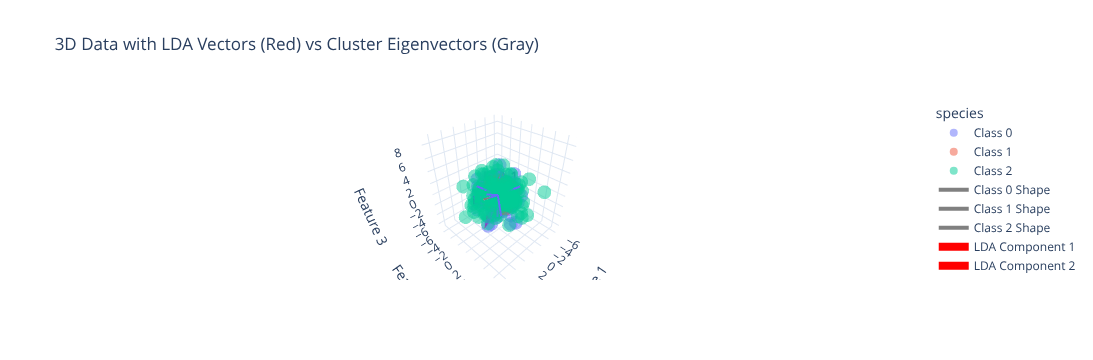

In [6]:
# --- B. Plot LDA Vectors (The Direction of Separation) ---
center = np.mean(X, axis=0)
scalings = lda.scalings_
arrow_scale = 5.0

for i in range(scalings.shape[1]):
    vector = scalings[:, i]
    end_point = center + (vector * arrow_scale)
    
    # Line
    fig_3d.add_trace(go.Scatter3d(
        x=[center[0], end_point[0]],
        y=[center[1], end_point[1]],
        z=[center[2], end_point[2]],
        mode='lines+text',
        text=['', f'<b>LDA-{i+1}</b>'],
        textposition='top center',
        line=dict(color='red', width=8), # Thicker and Red
        name=f'LDA Component {i+1}'
    ))
    
    # Cone Tip
    fig_3d.add_trace(go.Cone(
        x=[end_point[0]], y=[end_point[1]], z=[end_point[2]],
        u=[vector[0]], v=[vector[1]], w=[vector[2]],
        sizemode="absolute", sizeref=2, anchor="tail",
        showscale=False, colorscale=[[0, 'red'], [1, 'red']],
        name=f'LD{i+1} Arrow'
    ))

fig_3d.update_layout(
    template='plotly_white', 
    scene=dict(
        xaxis_title='Feature 1',
        yaxis_title='Feature 2',
        zaxis_title='Feature 3'
    )
)
fig_3d.show()

Generating Scatter Matrix...


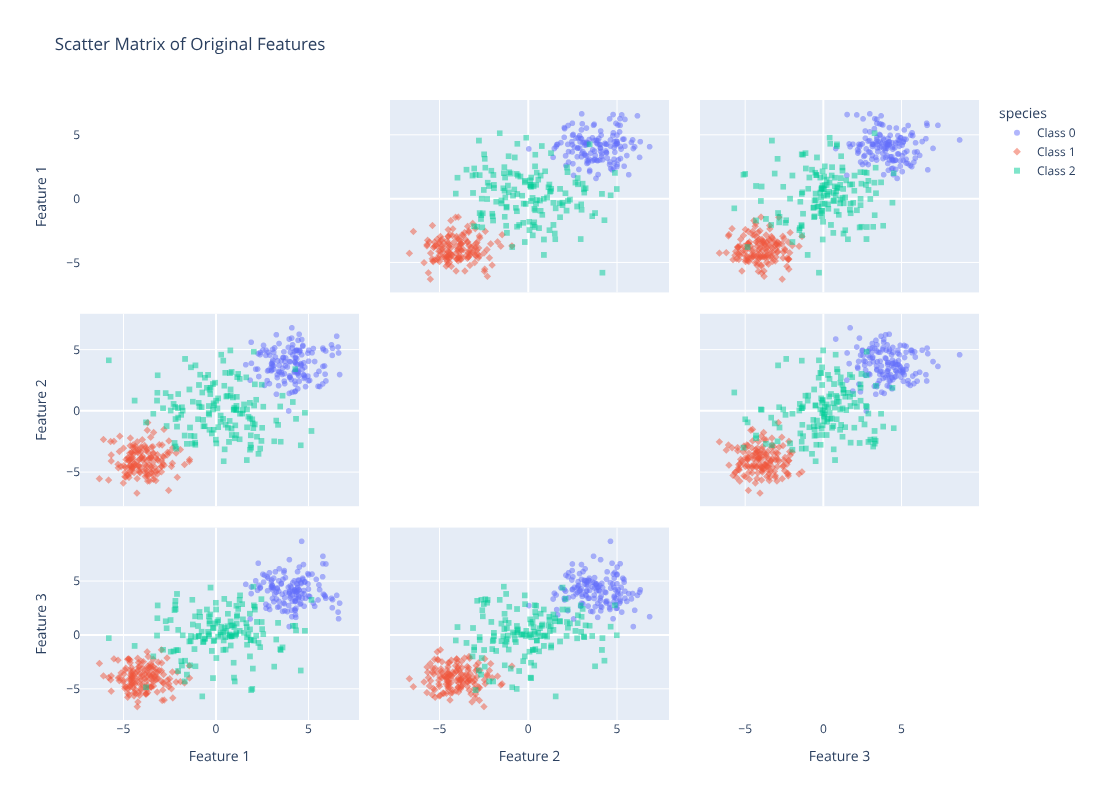

In [7]:
# ---------------------------------------------------------
# 4. Plot 2: Scatter Matrix
# ---------------------------------------------------------
print("Generating Scatter Matrix...")
fig_matrix = px.scatter_matrix(
    df,
    dimensions=feature_names,
    color="species",
    title="Scatter Matrix of Original Features",
    symbol="species",
    opacity=0.5,
    height=800
)
fig_matrix.update_traces(diagonal_visible=False)
fig_matrix.show()

Generating Eigenvalue Plot...


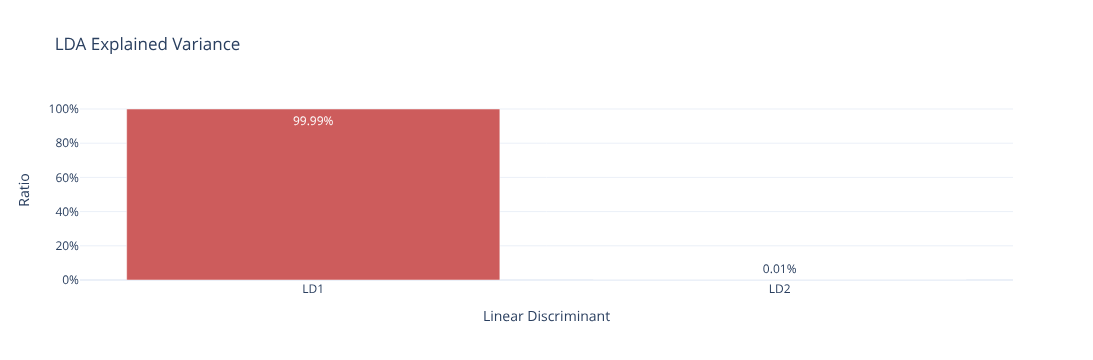

In [8]:
# ---------------------------------------------------------
# 5. Plot 3: Eigenvalues / Explained Variance
# ---------------------------------------------------------
print("Generating Eigenvalue Plot...")
explained_variance = lda.explained_variance_ratio_

fig_eigen = go.Figure(data=[
    go.Bar(
        x=[f'LD{i+1}' for i in range(len(explained_variance))],
        y=explained_variance,
        text=[f'{val:.2%}' for val in explained_variance],
        textposition='auto',
        marker_color='indianred'
    )
])
fig_eigen.update_layout(
    title='LDA Explained Variance',
    xaxis_title='Linear Discriminant',
    yaxis_title='Ratio',
    yaxis_tickformat='.0%',
    template='plotly_white'
)
fig_eigen.show()

Generating Projected Distribution Plot...


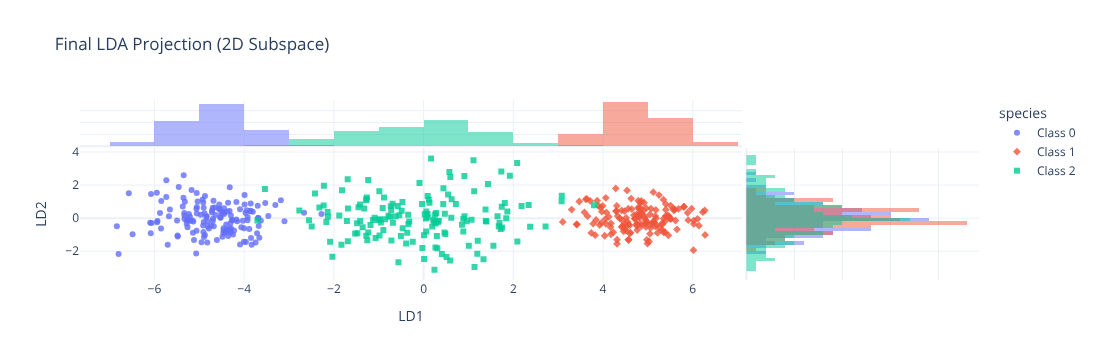

In [9]:

# ---------------------------------------------------------
# 6. Plot 4: Final 2D Projection
# ---------------------------------------------------------
print("Generating Projected Distribution Plot...")

lda_df = pd.DataFrame(data=X_r2, columns=['LD1', 'LD2'])
lda_df['species'] = df['species']

fig_projection = px.scatter(
    lda_df, 
    x='LD1', 
    y='LD2', 
    color='species',
    symbol='species',
    marginal_x="histogram",
    marginal_y="histogram",
    title="Final LDA Projection (2D Subspace)",
    opacity=0.8,
    template='plotly_white'
)
fig_projection.show()